In [1]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import requests
import io

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
df_content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
df_content['Month'] = pd.to_datetime(df_content['Month'], infer_datetime_format=True)
y = pd.Series(df_content["#Passengers"].values, index=df_content['Month'])
y = y.astype('f')

In [3]:
# 推移行列などの初期化
# 観測値は一次元とする
def FGHset(n_dim_trend, 
           n_dim_obs=1, n_dim_series=0, n_dim_ar=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0) + (n_dim_ar!=0)
    if n_dim_series>0 or n_dim_ar>0:
        n_dim_state = n_dim_trend + n_dim_series + n_dim_ar -1
    else:
        n_dim_state = n_dim_trend
        
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1

        start_elem = n_dim_trend + n_dim_series -1
        start_col = n_dim_trend + n_dim_series -1
            
    # AR成分のブロック行列の構築
    if n_dim_ar>0:
        G[start_elem, 2] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_ar): 
            F[start_elem, start_elem+i] = 0.5
        for i in range(n_dim_ar-1): 
            F[start_elem+i+1, start_elem+i] = 1

            
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

## 自己組織化 

In [4]:
from scipy.stats import multivariate_normal, cauchy, invgamma
from numpy.random import uniform
import copy


class GaussianNoise(object):
    """多次元ガウス分布
    """
    def __init__(self, covariance, update_target_idx=None):
        self.covariance = covariance
        self.n_state = len(covariance)
        self.update_target_idx = update_target_idx

    def generate(self, n_particles):
        """ノイズの生成
        """
        return multivariate_normal.rvs(np.zeros(self.n_state), 
                                       self.covariance, n_particles).T
    
    def pdf(self, y, predicted_obs):
        """確率密度
        """
        r_y = y.reshape(y.size)
        likelihoods = np.empty(predicted_obs.shape[1])
        for i, pred_y in enumerate(predicted_obs.T):
            likelihoods[i] = multivariate_normal.pdf(r_y, 
                                                     pred_y, 
                                                     cov=self.covariance)
        return likelihoods

    def update_parameters(self, particles):
        """分散共分散行列の要素の更新
        """
        n_row = len(self.covariance)
        self.covariance[range(n_row), range(n_row)] = np.exp(
            particles[self.update_target_idx].mean(axis=1))
    

class SelfOrganizationParticleFilter(object):
    def __init__(self, 
                 n_dim_state=None, n_dim_components=None,
                 n_dim_obs=None,
                 transition_func=None, transition_matrix=None,
                 observation_func=None, observation_matrix=None,
                 system_noise=None, observation_noise=None,
                 ar_param_noise=None, n_particles=None,
                 ar_param_idxs=None, ar_param_func=None,
                 Q_param_noise=None, Q_param_idxs=None):
        # 観測データの次元数
        self.n_dim_obs = n_dim_obs
        # 粒子の数
        self.n_particles = n_particles
        # リサンプリングに使用するクシ（使い回す）
        self.TEETH = np.arange(0, 1, float(1.0)/n_particles)
        # 粒子の単位質量（観測データへの適合度）
        self.weights = np.zeros(n_particles)
        # 粒子
        self.particles = np.zeros((n_dim_state, n_particles))
        # 予測分布（粒子）
        self.predicted_particles = np.zeros((n_dim_state, n_particles))
        self.n_dim_components = n_dim_components

        self.transition_func = transition_func
        self.transition_matrix = transition_matrix
        self.observation_func = observation_func
        self.observation_matrix = observation_matrix
        self.system_noise = system_noise
        self.observation_noise = observation_noise
        self.ar_param_noise = ar_param_noise
        self.ar_param_func = ar_param_func
        self.Q_param_noise = Q_param_noise

        self._init_praticles_distribution()
        self._ar_param_idxs = ar_param_idxs
        self._Q_param_idxs = Q_param_idxs
        self.n_target_params = \
            n_dim_state - len(ar_param_idxs) - len(Q_param_idxs)
        self.start_ar_dim = \
            n_dim_state - len(ar_param_idxs) * 2 - len(Q_param_idxs)
        
    def _init_praticles_distribution(self):
        """粒子の初期化
        x_{0|0}
        """
        self.particles = np.concatenate(
            [self.system_noise.generate(self.n_particles),
             self.ar_param_noise.generate(self.n_particles),
             self.Q_param_noise.generate(self.n_particles)],
            axis=0)

    def _update_transition_matrix(self):
        """遷移行列の更新（AR成分の更新）
        """
        for i, ar_idx in enumerate(self._ar_param_idxs):
            target_idx = self.start_ar_dim + i
            self.transition_matrix[self.start_ar_dim, target_idx] = \
                self.ar_param_func(self.particles[ar_idx].mean())
    
    def update(self, y):
        """リサンプリング
        """
        if isinstance(y, float):
            y = np.array([y])
        self._update_transition_matrix()
        self.system_noise.update_parameters(self.particles)
        self._update_particles()
        self._update_particles_weight(y)
        self._resample()

    def forecast(self):
        """長期予測
        """
        self.particles[:self.n_target_params] = \
            self.transition_func(self.particles[:self.n_target_params], 
                                 self.transition_matrix)
        return self.observation_func(self.particles[:self.n_target_params], 
                                     self.observation_matrix).mean(axis=1)

    def generate_system_noise(self):
        """v_t"""
        return self.system_noise.generate(self.n_particles)        
    
    def _update_particles(self):
        """システムモデルの計算（新たな粒子を生成することで予測分布を計算）
        x_{t|t-1}
        """
        # ハイパーパラメタ以外の予測分布
        par = (self.particles[:self.n_target_params] 
               + self.generate_system_noise())
        self.predicted_particles[:self.n_target_params] = \
            self.transition_func(par, self.transition_matrix)

        # ハイパーパラメタの粒子の予測分布
        # AR成分の予測分布
        self.predicted_particles[self._ar_param_idxs] = \
            (self.predicted_particles[self._ar_param_idxs]
             + self.ar_param_noise.generate(self.n_particles))

        # システムノイズの対角成分の予測分布
        self.predicted_particles[self._Q_param_idxs] = \
            (self.predicted_particles[self._Q_param_idxs]
             + self.Q_param_noise.generate(self.n_particles))
                        
    def _update_particles_weight(self, y):
        """各粒子の重みの計算（予測値が観測値に対してどれだけ適合しているかを計算）
        w_t
        """
        self.weights = self.observation_noise.pdf(
            y, self.observation_func(
                self.predicted_particles[:self.n_target_params], 
                self.observation_matrix))
        
    def _normalize_weights(self):
        """\tild{w}_t"""
        self.weights = self.weights / sum(self.weights)

    def _resample(self):
        """x_{t|t}"""
        self._normalize_weights()
        cum = np.cumsum(self.weights)
        
        # ルーレットを回す（粒子をランダムに選定するためのポインター生成）
        base = uniform(0, float(1.0)/self.n_particles)
        pointers = self.TEETH + base

        # 粒子の選定
        selected_idx = [np.where(cum>=p)[0][0] for p in pointers]
        self.particles = self.predicted_particles[:, selected_idx]

    def predict(self):
        """フィルタ系列の推定
        """
        pre_targete_dim = 0
        target_dim = 0
        results = []
        for n_dim_each in self.n_dim_components:
            target_dim += n_dim_each
            H = self.observation_matrix[:, pre_targete_dim:target_dim]
            matmul = self.observation_func(
                self.predicted_particles[pre_targete_dim:target_dim], 
                H)
            weighted = matmul * self.weights
            pre_targete_dim = target_dim
            results.append(np.sum(weighted, axis=1))
        return results

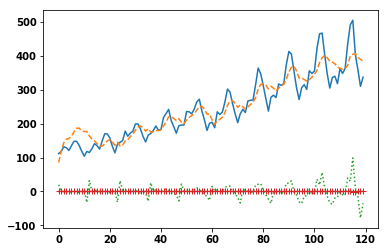

In [5]:
np.random.seed(555)

# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の
n_dim_series = 12
# AR成分の次数
n_dim_ar = 2
# 数値予測の際に成分を分けるため各成分の要素数を格納
n_dim_components = (n_dim_trend, n_dim_series-1, n_dim_ar)
# 粒子数
n_particles = 1000
# システムノイズの分散共分散行列の各要素の値
system_sigma2 = 1500

n_dim_state, F, H, Q = FGHset(n_dim_trend, 
                              n_dim_obs, 
                              n_dim_series, 
                              n_dim_ar, 
                              Q_sigma2=system_sigma2)

# 自己組織化するハイパーパラメタに該当する粒子のindex
ar_param_idxs = [idx for idx in range(n_dim_state, n_dim_state + n_dim_ar)]
Q_param_idxs = [idx for idx in range(ar_param_idxs[-1] + 1,
                                     ar_param_idxs[-1] + 1 + len(Q))]
n_dim_state += len(ar_param_idxs)
n_dim_state += len(Q_param_idxs)

# 観測ノイズの分散共分散行列の各要素の値
# 小さければ観測データに忠実にフィットしやすい
observation_sigma2 = 400

# AR係数はtanhで[-1, 1]の範囲で推定する
# そのためランダムウォークの分散はtanhの逆関数の出力とする
inv_tanh = lambda x: 0.5 * np.log((1 + x) / (1 - x))
ar_params_sigma2 = inv_tanh(0.25)

# システムノイズの分散共分散行列の要素は非負であり、推定時にはexp(x)とする
# そのためランダムウォークの分散は自然対数とする
# 大きくし過ぎると発散しやすい
Q_params_sigma2 = np.log(25)

# システム関数
transition_func = lambda x, F: F.dot(x)
# 観測関数
observation_func = lambda x, H: H.dot(x)
# システムノイズオブジェクトのインスタンス生成
system_noise = GaussianNoise(Q, Q_param_idxs)
# 観測ノイズオブジェクトのインスタンス生成
observation_noise = GaussianNoise(
    np.eye(n_dim_obs) * observation_sigma2)
# AR成分のノイズオブジェクトのインスタンス生成
ar_param_noise = GaussianNoise(
    np.eye(len(ar_param_idxs)) * ar_params_sigma2)
# AR係数を推定する際の復元関数
ar_param_func = lambda x: np.tanh(x)
# システムノイズ共分散行列の要素のノイズオブジェクトのインスタンス生成
Q_param_noise = GaussianNoise(np.eye(len(Q_param_idxs)) * Q_params_sigma2)

pf = SelfOrganizationParticleFilter(n_dim_state=n_dim_state, 
                                    n_dim_components=n_dim_components,
                                    n_dim_obs=n_dim_obs,
                                    transition_func=transition_func,
                                    transition_matrix=F,
                                    observation_func=observation_func,
                                    observation_matrix=H,
                                    system_noise=system_noise,
                                    observation_noise=observation_noise,
                                    ar_param_noise=ar_param_noise,
                                    n_particles=n_particles,
                                    ar_param_idxs=ar_param_idxs,
                                    ar_param_func=ar_param_func,
                                    Q_param_noise=Q_param_noise,
                                    Q_param_idxs=Q_param_idxs)

n_train = 120
predicted_trend = np.empty(n_train)
predicted_seasonal = np.empty(n_train)
predicted_ar = np.empty(n_train)
for i, d in enumerate(y[:n_train]):
    pf.update(d)
    results = pf.predict()
    predicted_trend[i] = results[0]
    predicted_seasonal[i] = results[1]
    predicted_ar[i] = results[2]

rng = range(n_train)
plt.plot(rng, y[:n_train], label="observation")
plt.plot(rng, predicted_trend, '--', label="trend")
plt.plot(rng, predicted_seasonal, ':', label="seasonal")
plt.plot(rng, predicted_ar, '+-', label="ar")

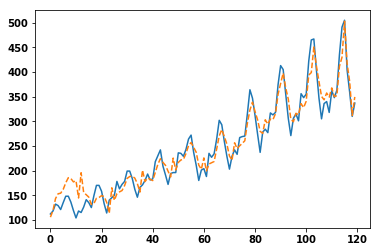

In [6]:
rng = range(n_train)
predicted = predicted_trend + predicted_seasonal + predicted_ar
plt.plot(rng, y[:n_train], label="observation")
plt.plot(rng, predicted, '--', label="predict")

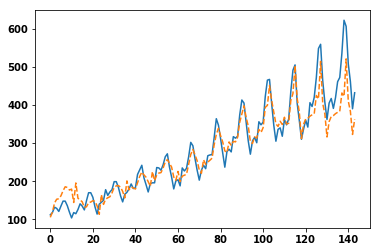

In [7]:
infered_value = np.empty(len(y[n_train:]))
for i, d in enumerate(y[n_train:]):
    infered_value[i] = pf.forecast()

rng = range(len(y))
plt.plot(rng, y.values, label="observation")
plt.plot(rng, 
         np.concatenate([predicted, infered_value]), 
         '--', label="forecast")